The point of this notebook is to imput the data and try the same "model" with diffent manipulations of the data, so see which model/data combination gives the best result.

Each dataset will first be run through a Decision Tree model, which will then form the basis for an AdaBoost model.

In [1]:
# Set up the environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [3]:
# Upload the original dataset - Subsets will be made off of this original dataframe
original = pd.read_csv('../data/processed/DecisionTreeData2010.csv', index_col=0)
to_drop = ['CITY', 'HIGHDEG', 'ADM_RATE', 'NetPrice', 'region','EnrollmentBins','Complete',\
           'TuitionBins','ExpenditureBins','FacultyBins', 'AVGFACSAL', 'RetentionPT', 'PCTFLOAN']
original = original.drop(to_drop, axis=1)
original.head()

,OPEID,INSTNM,NUMBRANCH,PREDDEG,CONTROL,UGDS,CURROPER,TUITFTE,INEXPFTE,PFTFAC,UG25abv,COMP_ORIG_YR4_RT,WDRAW_ORIG_YR4_RT,ENRL_ORIG_YR4_RT,DEBT_MDN,Year,Cost,RetentionFT
0,00100200,alabama a & m university,1,3,1,4930.0,True,6746.0,6601.0,0.8263,NaN,0.228753,0.233519,0.162828,19000.0,2010,13762.0,0.7457
7414,00100200,alabama a & m university,1,3,1,4112.0,True,4626.0,6841.0,0.7697,0.1400,0.249322,0.224029,0.144535,19484.5,2011,14965.0,0.6441
15089,00100200,alabama a & m university,1,3,1,4081.0,True,6222.0,8511.0,0.7509,0.1400,0.256983,0.228252,0.150838,19000.0,2012,17351.0,0.6766
22882,00100200,alabama a & m university,1,3,1,4051.0,True,9063.0,7459.0,0.8856,0.1049,0.256983,0.228252,0.150838,19500.0,2013,18888.0,0.6314
16,00100300,faulkner university,1,3,2,2334.0,True,9594.0,4245.0,0.9808,0.1049,0.156280,0.408437,0.052733,18041.0,2010,24105.0,0.6628


In [4]:
original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30682 entries, 0 to 26121
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   OPEID              30682 non-null  object 
 1   INSTNM             30682 non-null  object 
 2   NUMBRANCH          30682 non-null  int64  
 3   PREDDEG            30682 non-null  int64  
 4   CONTROL            30682 non-null  int64  
 5   UGDS               30682 non-null  float64
 6   CURROPER           30682 non-null  bool   
 7   TUITFTE            30682 non-null  float64
 8   INEXPFTE           30682 non-null  float64
 9   PFTFAC             30682 non-null  float64
 10  UG25abv            30681 non-null  float64
 11  COMP_ORIG_YR4_RT   30682 non-null  float64
 12  WDRAW_ORIG_YR4_RT  30682 non-null  float64
 13  ENRL_ORIG_YR4_RT   30682 non-null  float64
 14  DEBT_MDN           30682 non-null  float64
 15  Year               30682 non-null  int64  
 16  Cost               306

In [5]:
original_closed = original.loc[original.CURROPER == False]
original_closed.shape

(2759, 18)

In [6]:
original_open = original.loc[original.CURROPER==True]
original_open.shape

(27923, 18)

In [7]:
current_open = original_open.loc[original_open.Year > 2012]
current_open.shape

(7440, 18)

In [8]:
current = current_open.append(original_closed)
print("Shape:" , current.shape)
current.CURROPER.value_counts()

Shape: (10199, 18)


True     7440
False    2759
Name: CURROPER, dtype: int64

## Create the new datasets

In [9]:
# Original dataset, but resample the closed data by simply adding all it again
double_closed = current.append(original_closed)
print("Shape: ", double_closed.shape)
double_closed.CURROPER.value_counts()

Shape:  (12958, 18)


True     7440
False    5518
Name: CURROPER, dtype: int64

In [10]:
# Original dataset, but resample the closed data to be double in number
double_upsample = resample(original_closed, replace=True, n_samples=original_closed.shape[0]*2, random_state=123)
resample_double = pd.concat([current_open, double_upsample], axis=0)
print("Shape: ", resample_double.shape)
resample_double.CURROPER.value_counts()

Shape:  (12958, 18)


True     7440
False    5518
Name: CURROPER, dtype: int64

In [11]:
# Original dataset, but resample the closed data to make it the same size as the open class
closed_upsample = resample(original_closed, replace=True, n_samples=current_open.shape[0], random_state=123)
resample_closed = pd.concat([current_open, closed_upsample], axis=0)
print("Shape: ", resample_closed.shape)
resample_closed.CURROPER.value_counts()

Shape:  (14880, 18)


True     7440
False    7440
Name: CURROPER, dtype: int64

In [12]:
# Original dataset, but resample the closed data to make it half the size as the open class
full_open = current_open.shape[0]
half_open = int(full_open / 2)

closed_halfsample = resample(original_closed, replace=True, n_samples=half_open, random_state=123)
resample_half = pd.concat([current_open, closed_halfsample], axis=0)
print("Shape: ", resample_closed.shape)
resample_half.CURROPER.value_counts()

Shape:  (14880, 18)


True     7440
False    3720
Name: CURROPER, dtype: int64

In [13]:
# All closed bachelors schools from original, but only the last year for open bachelors schools
all_bach = original.loc[original.PREDDEG==3]
closed_bach = all_bach.loc[all_bach.CURROPER == False]
print("Closed bachelors shape: ", closed_bach.shape)
open_bach = all_bach.loc[all_bach.CURROPER == True]
current_bach = open_bach.loc[all_bach.Year > 2012]
print("Current open bachelors shape: ", current_bach.shape)
bachelor = pd.concat([closed_bach, current_bach], axis=0)
print("Shape: ", bachelor.shape)

Closed bachelors shape:  (241, 18)
Current open bachelors shape:  (2100, 18)
Shape:  (2341, 18)


In [14]:
# Resample the closed bachelor schools to be roughly equal to the number of open bachelors schools
bachelor_upsample = resample(closed_bach, replace=True, n_samples = current_bach.shape[0], random_state=123)
bachelor_resample = pd.concat([bachelor_upsample, current_bach], axis=0)
print("Shape: ", bachelor_resample.shape)
bachelor_resample.CURROPER.value_counts()

Shape:  (4200, 18)


True     2100
False    2100
Name: CURROPER, dtype: int64

In [15]:
current_dict = {'data':current}
double_closed_dict = {'data':double_closed}
resample_double = {'data':resample_double}
resample_closed_dict = {'data':resample_closed}
resample_half_dict = {'data':resample_half}
bachelor_dict = {'data':bachelor}
bachelor_resample_dict = {'data':bachelor_resample}

datasets = {'current':current_dict, 'double_closed':double_closed_dict, 'resample_double':resample_double,
            'resample_half':resample_half_dict, 'resample_closed':resample_closed_dict,
            'bachelor':bachelor_dict, 'bachelor_resample':bachelor_resample_dict}

## Create a pipeline/for loop to process all of the datasets.
First define functions to do the different modeling tasks that I want.

In [16]:
def tree_depth(X_train, X_test, y_train, y_test):
    max_depth = []
    acc_gini = []
    acc_entropy = []
    for i in range(1, 31):
        gtree = DecisionTreeClassifier(criterion='gini', max_depth=i, random_state=21)
        gtree.fit(X_train, y_train)
        gpredict = gtree.predict(X_test)
        acc_gini.append(metrics.accuracy_score(y_test, gpredict))
        ##
        etree = DecisionTreeClassifier(criterion='entropy', max_depth=i, random_state=21)
        etree.fit(X_train, y_train)
        epredict = etree.predict(X_test)
        acc_entropy.append(metrics.accuracy_score(y_test, epredict))
        ##
        max_depth.append(i)
        
    gini_max = max(acc_gini)
    gini_idx = acc_gini.index(gini_max)
    entropy_max = max(acc_entropy)
    entropy_idx = acc_entropy.index(entropy_max)

    if gini_max > entropy_max:
        depth = max_depth[gini_idx]
        crit = 'gini'
    else:
        depth = max_depth[entropy_idx]
        crit='entropy'
    
    return depth, crit
        

In [17]:
def AB_n_estimators(X_train, X_test, y_train, y_test, model):
    AB_depth = []
    score_b = []

    for i in range(105, 131, 1):
        btree = AdaBoostClassifier(model, n_estimators=i, random_state=21)
        btree.fit(X_train, y_train)
        bpredict = btree.predict(X_test)
        score_b.append(metrics.accuracy_score(y_test, bpredict))
        AB_depth.append(i)
        
    ideal_estimators = max(score_b)
    idx = score_b.index(ideal_estimators)
    return AB_depth[idx]

In [18]:
for dset in datasets:
    # Split into X and y
    data = datasets[dset]['data']
    y = data['CURROPER']
    X = data.drop(['CURROPER', 'OPEID', 'INSTNM', 'Year'], axis=1)
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=21, stratify=y)
    # Cycle through Decision Tree model to get best depth
    DTdepth, DTcrit = tree_depth(X_train, X_test, y_train, y_test)
    # Train Decision Tree model with best depth
    modelDT = DecisionTreeClassifier(criterion=DTcrit, max_depth=DTdepth, random_state=21)
    datasets[dset]['dt_model'] = modelDT.fit(X_train, y_train)
    datasets[dset]['dt_pred'] = modelDT.predict(X_test)
    datasets[dset]['dt_pred_prob'] = modelDT.predict_proba(X_test)
    datasets[dset]['y_test'] = y_test
    # Record metrics
    datasets[dset]['dt_confusion'] = metrics.confusion_matrix(y_test, datasets[dset]['dt_pred'])
    datasets[dset]['dt_classification'] = metrics.classification_report(y_test, datasets[dset]['dt_pred'])
#     importances = modelDT.feature_importances_
#     indices = np.argsort(importances)[::-1]
#     names = [X_train.columns[i] for i in indices]
#     datasets[dset]['dt_importance'] = list(zip(names, importances))
    
    # Cycle through AdaBoost model to get n_estimators
    n_est = AB_n_estimators(X_train, X_test, y_train, y_test, modelDT)
    # Train AdaBoost model with n_estimators
    modelAB = AdaBoostClassifier(modelDT, n_estimators=n_est, random_state=21)
    datasets[dset]['ab_model'] = modelAB.fit(X_train, y_train)
    datasets[dset]['ab_pred'] = modelAB.predict(X_test)
    datasets[dset]['ab_pred_prob'] = modelAB.predict_proba(X_test)
    
    # Record metrics
    datasets[dset]['ab_confusion'] = metrics.confusion_matrix(y_test, datasets[dset]['ab_pred'])
    datasets[dset]['ab_classification'] = metrics.classification_report(y_test, datasets[dset]['ab_pred'])
#     ABimportances = modelAB.feature_importances_
#     indices = np.argsort(ABimportances)[::-1]
#     datasets[dset]['ab_importance'] = list(zip(names, ABimportances))

In [19]:
AB_accuracy = []
AB_no_prec = []
AB_no_recall = []
for dset in datasets:
    acc = metrics.accuracy_score(datasets[dset]['y_test'], datasets[dset]['ab_pred'])
    prec = metrics.precision_score(datasets[dset]['y_test'], datasets[dset]['ab_pred'], pos_label = 0)
    rec = metrics.recall_score(datasets[dset]['y_test'], datasets[dset]['ab_pred'], pos_label = 0)
    AB_accuracy.append(acc)
    AB_no_prec.append(prec)
    AB_no_recall.append(rec)

In [22]:
models = [key for key in datasets.keys()]
names=['current', 'double','double-resamp','half', 'resample', 'bachelor', 'bach_resamp']

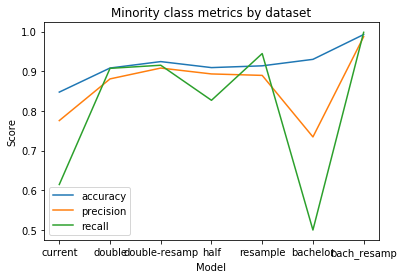

In [23]:
plt.plot(names, AB_accuracy, label='accuracy')
plt.plot(names, AB_no_prec, label='precision')
plt.plot(names, AB_no_recall, label = 'recall')
plt.ylabel('Score')
plt.xlabel('Model')
plt.title('Minority class metrics by dataset')
plt.legend()
plt.show()

In [30]:
print(AB_accuracy[2:5])#, max(AB_no_prec), max(AB_no_recall))

[0.9246399176954733, 0.9094982078853047, 0.9139784946236559]


In [31]:
print(AB_no_prec[2:5])

[0.908328340323547, 0.89351403678606, 0.889873417721519]


In [32]:
print(AB_no_recall[2:5])

[0.9154589371980676, 0.8270609318996416, 0.9448924731182796]


The idea resample ration seems to be somewhere between equal balance (50%) and (42%) (double minority)
The double_resample seems to give the best results...without restricting to just bachelors schools